# Basic Model Testing

In [1]:
import os
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import sys

In [2]:
mod1 = torch.load(sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth')

In [3]:
for name in mod1['state_dict']:
    print(name)

module.conv1.weight
module.bn1.weight
module.bn1.bias
module.bn1.running_mean
module.bn1.running_var
module.bn1.num_batches_tracked
module.layer1.0.conv1.weight
module.layer1.0.bn1.weight
module.layer1.0.bn1.bias
module.layer1.0.bn1.running_mean
module.layer1.0.bn1.running_var
module.layer1.0.bn1.num_batches_tracked
module.layer1.0.conv2.weight
module.layer1.0.bn2.weight
module.layer1.0.bn2.bias
module.layer1.0.bn2.running_mean
module.layer1.0.bn2.running_var
module.layer1.0.bn2.num_batches_tracked
module.layer1.1.conv1.weight
module.layer1.1.bn1.weight
module.layer1.1.bn1.bias
module.layer1.1.bn1.running_mean
module.layer1.1.bn1.running_var
module.layer1.1.bn1.num_batches_tracked
module.layer1.1.conv2.weight
module.layer1.1.bn2.weight
module.layer1.1.bn2.bias
module.layer1.1.bn2.running_mean
module.layer1.1.bn2.running_var
module.layer1.1.bn2.num_batches_tracked
module.layer2.0.conv1.weight
module.layer2.0.bn1.weight
module.layer2.0.bn1.bias
module.layer2.0.bn1.running_mean
module.lay

# Loading the Dataset

In [4]:
import os
import sys
sys.path.append(sys.path[0]+'/../lib') # Add library folder
#print(sys.path)

In [5]:
from opts import opts
from datasets.dataset_factory import get_dataset
from datasets.dataset.coco import COCO
from datasets.sample.ctdet import CTDetDataset
from trains.ctdet import CtdetTrainer
from trains.train_factory import train_factory

In [6]:
Dataset = get_dataset('coco', 'ctdet')

# Initializing opt

In [7]:
sys.path.append(sys.path[0]+'/../project_tools')
from fcn_opts import fcn_opts
opt = fcn_opts(Dataset)

Create opt for passing to the constructor. \
Also pass a string with the training value

## Loading Full Dataset

In [8]:
valset = Dataset(opt, 'val')

==> initializing coco 2017 val data.
loading annotations into memory...
Done (t=1.28s)
creating index...
index created!
Loaded val 5000 samples


In [10]:
dataset = Dataset(opt,'train')
valset = Dataset(opt, 'val')

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=18.75s)
creating index...
index created!
Loaded train 118287 samples
==> initializing coco 2017 val data.
loading annotations into memory...
Done (t=3.10s)
creating index...
index created!
Loaded val 5000 samples


## Modifying dataset

For initial testing we are modifying the dataset to a smaller size. The following code updates the json file list to use a smalller subset of the data. 

In [11]:
all_Ids=dataset.coco.getImgIds()
print(len(all_Ids))
import skimage.io as io
img_dir='~/MoDL_CenterNet/data/coco/train2017/'

118287


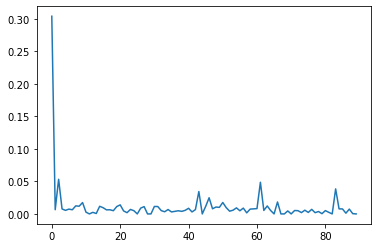

In [12]:
N=1024
import random
np.random.seed(0)
numsets=1
for iter in range(numsets):
    imgIds_perm=np.random.permutation(len(all_Ids))
    tmp=imgIds_perm[0:N].astype(int)
    tmp2=[all_Ids[t] for t in tmp]
    dataset.images=tmp2
    dataset.num_samples=len(dataset.images)
    sub_inst_cat=np.zeros(90)
    for j in range(N):
        sub_cat_lab=[]
        img = dataset.coco.loadImgs(dataset.images[j])[0]
        f_name=img_dir
        f_name+=img['file_name']
        annIds = dataset.coco.getAnnIds(imgIds=img['id'])
        anns = dataset.coco.loadAnns(annIds)
        sub_cat_lab=[k['category_id'] for k in anns]
        for jj in range(90):
            t=np.where(np.asarray(sub_cat_lab)==jj)
            sub_inst_cat[jj-1]+=t[0].shape[0]
    prob_sub=(sub_inst_cat+1)/np.sum(sub_inst_cat+1)    
    plt.plot(sub_inst_cat/(np.sum(sub_inst_cat)))
np.random.seed(2)

In [9]:
all_Ids=valset.coco.getImgIds()
print(len(all_Ids))
import skimage.io as io
img_dir='~/MoDL_CenterNet/data/coco/val2017/'

5000


In [10]:
N=1000
np.random.seed(0)
imgIds_perm=np.random.permutation(len(all_Ids))
tmp=imgIds_perm[0:N].astype(int)
tmp2=[all_Ids[t] for t in tmp]
valset.images=tmp2
valset.num_samples=len(valset.images)
np.random.seed(2)

In [11]:
opt.num_iters = dataset.num_samples/opt.batch_size
#print(dataset.images)

NameError: name 'dataset' is not defined

## Dataloader

In [15]:
train_loader = td.DataLoader(
      dataset, 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

In [16]:
val_loader = torch.utils.data.DataLoader(
      valset, 
      batch_size=1, 
      shuffle=False,
      num_workers=1,
      pin_memory=True
  )

# Model

In [17]:
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from models.model import create_model, load_model, save_model
from trains.ctdet import CtdetTrainer

In [18]:
# regression on center point.
opt.arch = 'resdcn_18'
model = create_model(opt.arch, opt.heads, opt.head_conv)

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution


In [19]:
optimizer = torch.optim.Adam(model.parameters(), opt.lr)

# Trainer

In [20]:
trainer = CtdetTrainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

# Running main training loop

In [21]:
## Test for Using their train function from Ctdetrainer
# print('Starting training...')
# best = 1e10
# for epoch in range(start_epoch + 1, opt.num_epochs + 1):
#     log_dict_train, _ = trainer.train(epoch, train_loader)
    

In [12]:
sys.path.append(sys.path[0]+"/../project_tools")
import nntools as nt

In [23]:
for name,param in model.named_parameters():
    if name[0:2]=='hm' or name[0:2]=='re' or name[0:2]=='wh':
        print(param.size())
        print(torch.randn(param.size()))
    else:
        param.requires_grad=False

torch.Size([64, 64, 3, 3])
tensor([[[[ 1.4320,  1.2854,  0.2295],
          [ 1.3652, -2.0680,  0.5874],
          [ 0.5714, -0.1644, -0.4560]],

         [[ 0.5019, -0.5767, -0.3474],
          [ 0.3856,  0.7766,  0.5399],
          [-0.3500,  0.1196,  0.2251]],

         [[-1.2624,  0.1419,  1.7389],
          [ 1.6346, -0.1230,  0.5831],
          [-0.8606,  0.8615,  0.7467]],

         ...,

         [[ 0.3844, -2.0988,  0.2071],
          [-0.6334, -2.0589, -0.0419],
          [-0.1095,  1.2701, -0.5917]],

         [[-1.1322,  0.0686,  1.2477],
          [ 1.0606,  0.7760, -0.9078],
          [ 0.8578,  0.3369,  0.5364]],

         [[-2.3199, -1.2545,  0.1459],
          [ 1.2843,  1.0481, -0.6986],
          [ 0.3269, -2.6832,  0.4318]]],


        [[[-0.1249, -0.3330,  0.7191],
          [ 1.8484, -0.6842,  0.5880],
          [ 0.5911,  0.0599,  0.6718]],

         [[ 0.3680,  0.5842,  1.4979],
          [-1.2689,  1.0920,  0.3866],
          [ 0.3789, -0.7215,  0.4908]],

    

In [17]:
class Centernet_model(nt.NeuralNetwork,CtdetTrainer):
    def __init__(self,opt,model,optimizer=None,FineTune=True):
        nt.NeuralNetwork.__init__(self)
        CtdetTrainer.__init__(self,opt,model,optimizer=None)
        if FineTune:
            for name,param in model.named_parameters():
               if name[0:2]=='hm' or name[0:2]=='re' or name[0:2]=='wh':
                    param = torch.randn(param.size()) # Random initialization
               else: 
                    param.requires_grad=False
            #print(name,param.requires_grad)
        self.model=model
        self.opt=opt
    def forward(self,x):
        return self.model(x)
    def criterion(self, y, d):
        return self.loss(y,d)

In [25]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    #image=np.int(((image-np.min(image))/(np.max(image)-np.min(image)))*255)
    #print(image.shape)
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [26]:
model1 =load_model(model,sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth');
net = Centernet_model(opt,model1);
net = net.to(opt.device)
train_loader = td.DataLoader(
      dataset, 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

loaded /datasets/home/home-01/40/940/rpote/MoDL_CenterNet/src/local_notebooks/../../models/ctdet_coco_resdcn18.pth, epoch 140


## Data Augmentation

0


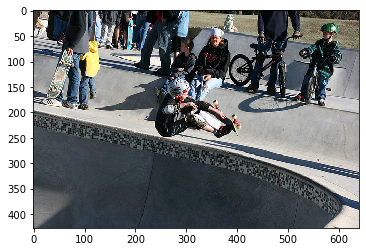

torch.Size([3, 512, 512]) (427, 640, 3)
1


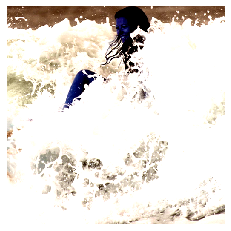

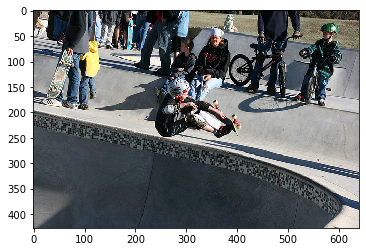

torch.Size([3, 512, 512]) (427, 640, 3)
2


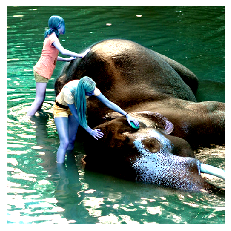

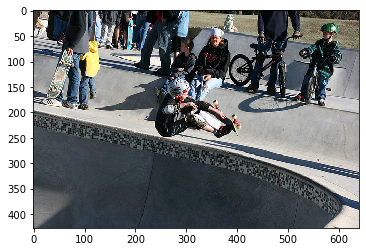

torch.Size([3, 512, 512]) (427, 640, 3)
3


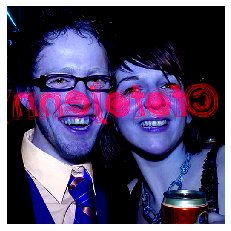

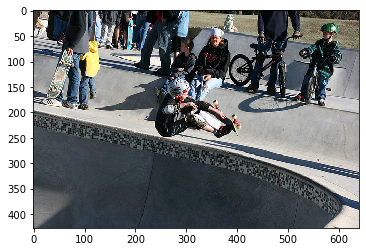

torch.Size([3, 512, 512]) (427, 640, 3)
4


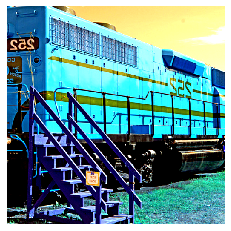

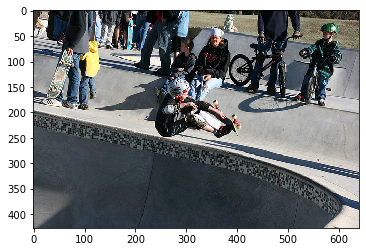

torch.Size([3, 512, 512]) (427, 640, 3)
5


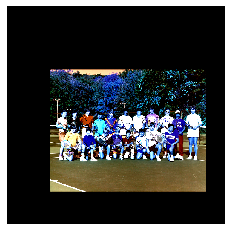

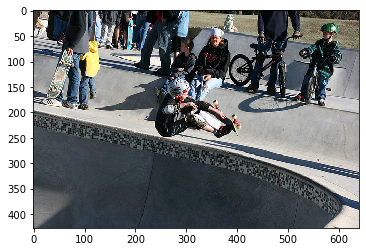

torch.Size([3, 512, 512]) (427, 640, 3)
6


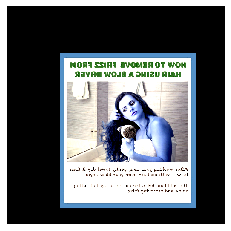

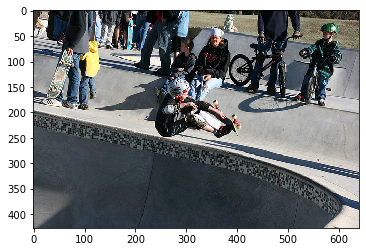

torch.Size([3, 512, 512]) (427, 640, 3)
7


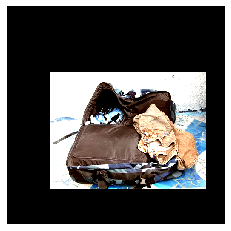

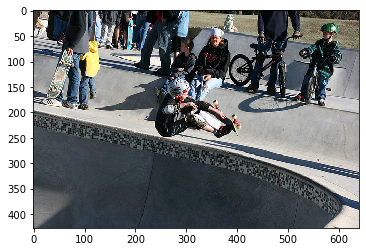

torch.Size([3, 512, 512]) (427, 640, 3)


KeyboardInterrupt: 

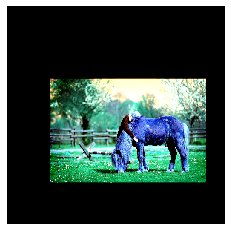

In [32]:
import cv2
import skimage.io as io
for idx,batch in enumerate(train_loader):
    print(idx)
    x1=batch['input']
    img = dataset.coco.loadImgs(dataset.images[0])[0]
    f_name=img_dir
    f_name+=img['file_name']
    I = io.imread(f_name)
    plt.figure()
    plt.imshow(I)
    plt.show()
    #x = np.moveaxis(x, [0, 1, 2], [2, 0, 1])
    #     plt.figure()
    #     plt.imshow(x)
    #     plt.show()
    myimshow(x1[0,:,:,:])
    print(x1[0,:,:,:].shape,I.shape)

In [33]:
torch.equal(x,x1)
print()

NameError: name 'x' is not defined

In [ ]:
import cv2
import skimage.io as io
for idx,batch in enumerate(train_loader):
    x=batch['input']
    img = dataset.coco.loadImgs(dataset.images[0])[0]
    f_name=img_dir
    f_name+=img['file_name']
    I = io.imread(f_name)
    plt.figure()
    plt.imshow(I)
    plt.show()
    #x = np.moveaxis(x, [0, 1, 2], [2, 0, 1])
    #     plt.figure()
    #     plt.imshow(x)
    #     plt.show()
    myimshow(x[0,:,:,:])
    print(x[0,:,:,:].shape,I.shape)

## Manual Batch Loss computation

In [27]:
for idx,batch in enumerate(train_loader):
    #print(idx)
    for k in batch:
        if k != 'meta':
            batch[k] = batch[k].to(device=opt.device, non_blocking=True) 
    y=net.model(batch['input'])
    #y=net.model(batch['input'])
    #batch = batch.to(net.device)
    #y,_,_=net.model_with_loss(batch)
    #print(idx)
    loss1,_ = net.loss(y,batch)

NameError: name 'net' is not defined

In [ ]:
print(loss1.mean())

In [31]:
for name,param in net.model.named_parameters():
    print(name,param.size(),param.requires_grad)

conv1.weight torch.Size([64, 3, 7, 7]) False
bn1.weight torch.Size([64]) False
bn1.bias torch.Size([64]) False
layer1.0.conv1.weight torch.Size([64, 64, 3, 3]) False
layer1.0.bn1.weight torch.Size([64]) False
layer1.0.bn1.bias torch.Size([64]) False
layer1.0.conv2.weight torch.Size([64, 64, 3, 3]) False
layer1.0.bn2.weight torch.Size([64]) False
layer1.0.bn2.bias torch.Size([64]) False
layer1.1.conv1.weight torch.Size([64, 64, 3, 3]) False
layer1.1.bn1.weight torch.Size([64]) False
layer1.1.bn1.bias torch.Size([64]) False
layer1.1.conv2.weight torch.Size([64, 64, 3, 3]) False
layer1.1.bn2.weight torch.Size([64]) False
layer1.1.bn2.bias torch.Size([64]) False
layer2.0.conv1.weight torch.Size([128, 64, 3, 3]) False
layer2.0.bn1.weight torch.Size([128]) False
layer2.0.bn1.bias torch.Size([128]) False
layer2.0.conv2.weight torch.Size([128, 128, 3, 3]) False
layer2.0.bn2.weight torch.Size([128]) False
layer2.0.bn2.bias torch.Size([128]) False
layer2.0.downsample.0.weight torch.Size([128, 64

## Experiment with custom function run2

In [19]:
adam = torch.optim.Adam(net.parameters(), lr=opt.lr)
stats_manager = nt.StatsManager()
exp2 = nt.Experiment(net,dataset,valset,adam,stats_manager,
output_dir="BaseExperiment", batch_size=opt.batch_size,perform_validation_during_training=False)

NameError: name 'net' is not defined

In [25]:
exp2.run2(num_epochs=5)

Start/Continue training from epoch 0
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size

torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size

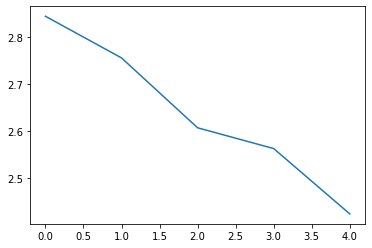

In [26]:
plt.plot(exp2.history)
plt.show()

### Pre-Trained model absolute value of Loss

In [25]:
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from models.model import create_model, load_model, save_model
from trains.ctdet import CtdetTrainer

In [26]:
model_pretrain = create_model(opt.arch, opt.heads, opt.head_conv)
optimizer_pretrain = torch.optim.Adam(model_pretrain.parameters(), opt.lr)
model_pretrain =load_model(model_pretrain,sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth');
net_pretrain = Centernet_model(opt,model_pretrain);
net_pretrain = net_pretrain.to(opt.device)

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution
loaded /datasets/home/home-01/40/940/rpote/MoDL_CenterNet/src/local_notebooks/../../models/ctdet_coco_resdcn18.pth, epoch 140


In [27]:
adam_pretrain = torch.optim.Adam(net_pretrain.parameters(), lr=opt.lr)
stats_manager_pretrain = nt.StatsManager()
exp2 = nt.Experiment(net_pretrain,dataset,dataset,adam_pretrain,stats_manager_pretrain,
output_dir="BaseExperiment_PreTrain", batch_size=opt.batch_size,perform_validation_during_training=False)

In [23]:
exp2.evaluate2()

/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


2.9636004106141627

In [24]:
exp2.stats_manager.number_update

256

### Changing wh_weight to 1

In [102]:
print('The default value for width-height loss weight is', opt.wh_weight)
opt.wh_weight = 1
print('The new value for width-height loss weight is', opt.wh_weight)

The default value for width-height loss weight is 0.1
The new value for width-height loss weight is 1


In [103]:
model_whwt = create_model(opt.arch, opt.heads, opt.head_conv) # wh-weight test
optimizer_whwt = torch.optim.Adam(model_whwt.parameters(), opt.lr)
model_whwt =load_model(model_whwt,sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth');
net_whwt = Centernet_model(opt,model_whwt);
net_whwt = net_whwt.to(opt.device)

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution
loaded /datasets/home/home-01/40/940/rpote/MoDL_CenterNet/src/local_notebooks/../../models/ctdet_coco_resdcn18.pth, epoch 140


In [104]:
adam_whwt = torch.optim.Adam(net_whwt.parameters(), lr=opt.lr)
stats_manager_whwt = nt.StatsManager()
exp_whwt = nt.Experiment(net_whwt,dataset,valset,adam_whwt,stats_manager_whwt,
output_dir="BaseExperiment__WHwt", batch_size=opt.batch_size,perform_validation_during_training=False)

In [105]:
exp_whwt.run2(num_epochs=100)

Start/Continue training from epoch 100
Finish training for 100 epochs


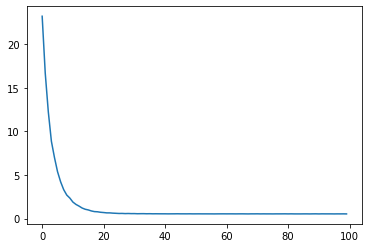

In [106]:
plt.plot(exp_whwt.history)
plt.show()

In [107]:
exp_whwt.history

[23.19815879315138,
 16.66849122568965,
 12.224816009402275,
 8.860405251383781,
 6.994718257337809,
 5.36864616535604,
 4.210261516273022,
 3.3093958171084523,
 2.6883604023605585,
 2.343873563222587,
 1.8833401449956,
 1.6132111116312444,
 1.419749468099326,
 1.2006702716462314,
 1.0601744493469596,
 0.9827106664888561,
 0.8668826634529978,
 0.7907412010245025,
 0.7707593685481697,
 0.7144769195001572,
 0.6834587610792369,
 0.6458060939330608,
 0.6433002804405987,
 0.6138359261676669,
 0.5960776682477444,
 0.5767089216969907,
 0.5819720972795039,
 0.5631255528423935,
 0.5732191081624478,
 0.5609697361942381,
 0.5626578838564456,
 0.5472601398359984,
 0.5537062846124172,
 0.5552208793815225,
 0.5442079168278724,
 0.5501975796651095,
 0.539662011899054,
 0.5435760717373341,
 0.5396517782937735,
 0.5381590495817363,
 0.5377337036188692,
 0.5324945598840714,
 0.5358019485138357,
 0.5372703413013369,
 0.5421713620889932,
 0.5359705386217684,
 0.5357955573126674,
 0.5335080255754292,
 0.53

In [33]:
exp_whwt.evaluate2()

0.5826892800396308

In [36]:
exp_whwt.evaluate2()

0.5789077454246581

In [ ]:
exp_whwt.net.eval()
with torch.no_grad():
    for x, d in enumerate(exp_whwt.val_loader):
        for k in d:
            if k != 'meta':
                d[k] = d[k].to(device=exp_whwt.net.device, non_blocking=True)
        exp_whwt.optimizer.zero_grad()
        y = self.net.forward(d['input'])
        loss, _ = self.net.criterion(y, d)
        self.stats_manager.accumulate(loss.item(), x, y, d)
self.net.train()

In [111]:
valloader = td.DataLoader(valset, batch_size=1, shuffle=False, drop_last=True, pin_memory=True)

In [117]:
valset.

[397133,
 37777,
 252219,
 87038,
 174482,
 403385,
 6818,
 480985,
 458054,
 331352,
 296649,
 386912,
 502136,
 491497,
 184791,
 348881,
 289393,
 522713,
 181666,
 17627,
 143931,
 303818,
 463730,
 460347,
 322864,
 226111,
 153299,
 308394,
 456496,
 58636,
 41888,
 184321,
 565778,
 297343,
 336587,
 122745,
 219578,
 555705,
 443303,
 500663,
 418281,
 25560,
 403817,
 85329,
 329323,
 239274,
 286994,
 511321,
 314294,
 233771,
 475779,
 301867,
 312421,
 185250,
 356427,
 572517,
 270244,
 516316,
 125211,
 562121,
 360661,
 16228,
 382088,
 266409,
 430961,
 80671,
 577539,
 104612,
 476258,
 448365,
 35197,
 349860,
 180135,
 486438,
 400573,
 109798,
 370677,
 238866,
 369370,
 502737,
 515579,
 515445,
 173383,
 438862,
 180560,
 347693,
 39956,
 321214,
 474028,
 66523,
 355257,
 142092,
 63154,
 199551,
 239347,
 514508,
 473237,
 228144,
 206027,
 78915,
 551215,
 544519,
 96493,
 23899,
 340175,
 578500,
 366141,
 57597,
 559842,
 434230,
 428454,
 399462,
 261061,
 1

In [119]:
for k in valset[1]:
    print(k)

input
hm
reg_mask
ind
dense_wh
dense_wh_mask
reg
meta


In [70]:
valset.__getitem__(0)['input'].shape

(3, 512, 512)

## Detector

In [13]:
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from detectors.ctdet import CtdetDetector

In [14]:
opt.load_model = '/datasets/home/home-01/40/940/rpote/MoDL_CenterNet/models/ctdet_coco_resdcn18.pth'
opt.dataset = 'coco'
opt.debugger_theme = 'white'
opt.flip_test = True
opt.K = 100
opt.nms = True
opt.vis_thresh = 0.3

In [15]:
detector = CtdetDetector(opt)
#detector.model = exp_whwt.net.model

Creating model...
=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution
loaded /datasets/home/home-01/40/940/rpote/MoDL_CenterNet/models/ctdet_coco_resdcn18.pth, epoch 140


In [16]:
for tst_id in range(len(valset)+1):
    print(valset.images[tst_id])

158548
457848
522393
340272
327601
365207
77396
573258
278848
269866
248810
127270
152870
162092
290248
274066
297578
545219
30828
6763
450758
240767
559956
22192
282298
431848
428280
498919
540502
59044
320232
505942
92939
369503
262631
426836
291551
222825
569972
92091
260261
144003
529528
46872
116208
107087
509735
429530
202228
298738
257865
402096
186980
455981
567011
353970
9769
140840
356261
409424
271471
537506
328117
115870
31620
46252
474786
445834
179285
240250
547816
234413
356248
70229
414385
234807
507975
263796
500826
129756
491130
369081
6012
545129
226408
26690
121591
434204
313454
286660
102805
30504
569700
281179
152740
32334
517069
459437
369812
384136
128476
154644
370208
306582
33114
324715
533145
527220
485424
308328
168330
389933
96001
544444
48555
208423
495732
560911
257478
4795
369757
291634
273711
156372
215644
66561
331817
472298
387383
364126
506656
513181
136600
18575
36861
469828
269316
76547
505789
303893
49761
504711
42888
276055
389451
292330
448263
5

IndexError: list index out of range

In [17]:
tst_id

1000

In [18]:
results = {}
for tst_id in range(len(valset)):
    img_id = valset.images[tst_id]
    img_info = valset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(valset.img_dir, img_info['file_name'])
    ret = detector.run(img_path)
    results[img_id] = ret['results']

In [19]:
print([(ret['results'][i+1].shape[0],i+1) for i in range(80)])

[(12, 1), (2, 2), (11, 3), (0, 4), (0, 5), (4, 6), (2, 7), (6, 8), (2, 9), (0, 10), (3, 11), (1, 12), (1, 13), (7, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (1, 25), (6, 26), (6, 27), (1, 28), (0, 29), (0, 30), (0, 31), (0, 32), (4, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (3, 40), (0, 41), (5, 42), (0, 43), (0, 44), (0, 45), (1, 46), (0, 47), (0, 48), (0, 49), (1, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (3, 57), (0, 58), (9, 59), (0, 60), (0, 61), (0, 62), (2, 63), (0, 64), (0, 65), (0, 66), (0, 67), (4, 68), (0, 69), (0, 70), (0, 71), (1, 72), (0, 73), (0, 74), (2, 75), (0, 76), (0, 77), (0, 78), (0, 79), (0, 80)]


{'license': 3, 'file_name': '000000007088.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000007088.jpg', 'height': 640, 'width': 478, 'date_captured': '2013-11-18 11:30:36', 'flickr_url': 'http://farm6.staticflickr.com/5294/5572813280_0ff7f31d99_z.jpg', 'id': 7088}


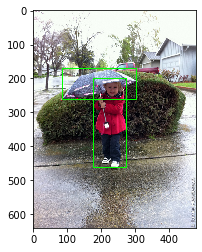

In [20]:
#for kk in valset[0]:
#    print(kk)
import cv2
im_id = valset[tst_id]['meta']['img_id']
img = valset.coco.loadImgs(im_id)[0]
print(img)
img_dir='~/MoDL_CenterNet/data/coco/val2017/'
f_name=img_dir
f_name+=img['file_name']
import skimage.io as io
I = io.imread(f_name)
for c_id in range(80):
    for j in range(ret['results'][c_id+1].shape[0]):
        if ret['results'][c_id+1][j][4]>=opt.vis_thresh:
            cv2.rectangle(I, (ret['results'][c_id+1][j][0], ret['results'][c_id+1][j][1]),(ret['results'][c_id+1][j][2], ret['results'][c_id+1][j][3]), (0,255,0), 2)
plt.imshow(I)
#im=np.moveaxis(im,[0,1,2],[2,0,1])
#im = im.reshape(512,512,3)
#cv2
#print(im.shape)

{'license': 3, 'file_name': '000000007088.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000007088.jpg', 'height': 640, 'width': 478, 'date_captured': '2013-11-18 11:30:36', 'flickr_url': 'http://farm6.staticflickr.com/5294/5572813280_0ff7f31d99_z.jpg', 'id': 7088}


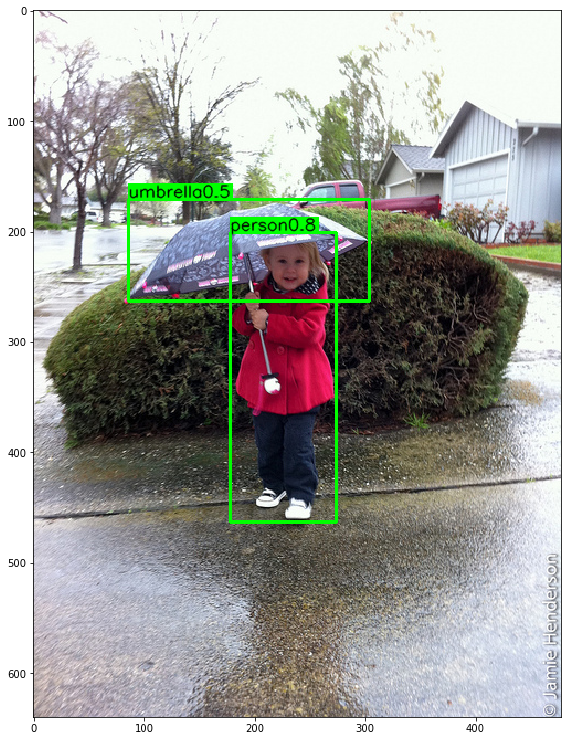

In [21]:
coco_class_name = [
     'person', 'bicycle', 'car', 'motorcycle', 'airplane',
     'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
     'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
     'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
     'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
     'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
     'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
     'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
     'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
     'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
     'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
     'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
     'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

#for kk in valset[0]:
#    print(kk)

import cv2
im_id = valset[tst_id]['meta']['img_id']
img = valset.coco.loadImgs(im_id)[0]
print(img)
img_dir='~/MoDL_CenterNet/data/coco/val2017/'
f_name=img_dir
f_name+=img['file_name']
import skimage.io as io
I = io.imread(f_name)
show_txt = True
for c_id in range(80):
    for j in range(ret['results'][c_id+1].shape[0]):
        if ret['results'][c_id+1][j][4]>=opt.vis_thresh:
            bbox = ret['results'][c_id+1][j]
            cv2.rectangle(I, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,255,0), 2)
            if show_txt:
                txt = '{}{:.1f}'.format(coco_class_name[c_id], bbox[4]) # text+confidence
                font = cv2.FONT_HERSHEY_SIMPLEX
                cat_size = cv2.getTextSize(txt, font, 0.5, 2)[0]
                cv2.rectangle(I, (bbox[0], int(bbox[1] - cat_size[1] - 2)),(int(bbox[0] + cat_size[0]), int(bbox[1] - 2)), (0,255,0), -1)
                cv2.putText(I, txt, (bbox[0], int(bbox[1] - 2)), font, 0.5, (0, 0, 0),thickness=1, lineType=cv2.LINE_AA)


fig, axes = plt.subplots(figsize=(13,13))
axes.imshow(I)
#im=np.moveaxis(im,[0,1,2],[2,0,1])
#im = im.reshape(512,512,3)
#cv2
#print(im.shape)

In [22]:
print(img_info)
# print(type(img_info))
# print(img_path)
print(sum([ret['results'][i+1].shape[0] for i in range(80)]))

{'license': 3, 'file_name': '000000007088.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000007088.jpg', 'height': 640, 'width': 478, 'date_captured': '2013-11-18 11:30:36', 'flickr_url': 'http://farm6.staticflickr.com/5294/5572813280_0ff7f31d99_z.jpg', 'id': 7088}
100


In [23]:
opt.save_dir = sys.path[0]+'/results'
valset.run_eval(results, opt.save_dir)

Loading and preparing results...
DONE (t=1.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=23.30s).
Accumulating evaluation results...
DONE (t=4.87s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.098
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.107
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.053
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

In [26]:
results={}
results[img_id] = ret['results']

In [26]:
6.4*5

32.0

In [29]:
opt.save_dir

'/datasets/home/home-01/40/940/rpote/MoDL_CenterNet/src/local_notebooks/../../exp/ctdet/exp0'

In [27]:
opt.chunk_sizes

[8]

In [34]:
opt.root_dir

'/datasets/home/home-01/40/940/rpote/MoDL_CenterNet/src/local_notebooks/../../'

In [ ]:
## Opts print for train

# Not in fcn_opts
K=100, 
aggr_weight=0.0, 
agnostic_ex=False,
aug_ddd=0.5, 
aug_rot=0,
center_thresh=0.1,
dataset='coco',
debugger_theme='white',
demo='', 
dense_hp=False,
dep_weight=1, 
dim_weight=1, 
eval_oracle_dep=False, 
eval_oracle_hmhp=False, 
eval_oracle_hp_offset=False, 
eval_oracle_kps=False,
flip_test=False, 
gpus_str='0,1,2,3'
hm_hp=True, 
hm_hp_weight=1,
hp_weight=1,
kitti_split='3dop', 
metric='loss',
nms=False,
not_hm_hp=False,
not_prefetch_test=False,
not_reg_bbox=False, 
not_reg_hp_offset=False,
num_iters=-1,
peak_thresh=0.2,
rect_mask=False,
reg_bbox=True, 
reg_hp_offset=True,
rot_weight=1,
save_all=False,
scores_thresh=0.1,
vis_thresh=0.3,


# Set correctly
arch='resdcn_18', 
cat_spec_wh=False, 
data_dir='/datasets/home/home-01/40/940/rpote/MoDL_CenterNet/src/lib/../../data',
debug=0,
debug_dir='/datasets/home/home-01/40/940/rpote/MoDL_CenterNet/src/lib/../../exp/ctdet/coco_resdcn18/debug',
down_ratio=4,
eval_oracle_offset=False, 
eval_oracle_wh=False, 
exp_dir='/datasets/home/home-01/40/940/rpote/MoDL_CenterNet/src/lib/../../exp/ctdet',
fix_res=True,
flip=0.5, 
head_conv=64, 
heads={'hm': 80, 'wh': 2, 'reg': 2},
hm_weight=1,
input_h=512, 
input_res=512, 
input_w=512,
keep_res=False
load_model='', 
lr_step=[90, 120],
mean=array([[[0.40789655, 0.44719303, 0.47026116]]], dtype=float32), # probably right 
not_reg_offset=False,
num_classes=80,  
num_stacks=1,
off_weight=1, 
output_h=128,
output_res=128, 
output_w=128, 
pad=31,  
reg_loss='l1',
reg_offset=True,
root_dir='/datasets/home/home-01/40/940/rpote/MoDL_CenterNet/src/lib/../..', 
rotate=0, 
scale=0.4, 
shift=0.1, 
std=array([[[0.2886383 , 0.27408165, 0.27809834]]], dtype=float32), # probably right 
task='ctdet', 
test=False, 
test_scales=[1.0],
wh_weight=0.1


# Set wrongly or differently
batch_size=114,
chunk_sizes=[18, 32, 32, 32] # our=[8]
dense_wh=False,
eval_oracle_hm=False,
exp_id='coco_resdcn18', 
gpus=[0, 1, 2, 3], # set as [0]
hide_data_time=False,
lr=0.0005,
master_batch_size=18, 
mse_loss=False, 
no_color_aug=False, 
norm_wh=False
not_cuda_benchmark=False
not_rand_crop=False,
num_epochs=140,
num_workers=16
print_iter=0,
resume=False, 
save_dir='/datasets/home/home-01/40/940/rpote/MoDL_CenterNet/src/lib/../../exp/ctdet/coco_resdcn18',
seed=317,
trainval=False, 
val_intervals=5, 